In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import joblib
import os

In [32]:
import sys
print(sys.executable)


/Users/m.pratyush/Desktop/code project/cnn_env/bin/python


In [33]:


DATA_PATH = "diabetes_prediction_dataset.csv"  # update path in Colab (upload file or mount Drive)
OUT_MODEL = "cnn_diabetes_model.h5"
OUT_SCALER = "cnn_diabetes_scaler.joblib"
OUT_PLOT_HISTORY = "training_history.png"
OUT_PLOT_CM = "confusion_matrix.png"


In [ ]:

target_col = next((c for c in ['Diabetic','Outcome','diabetes','diabetic','class','target','readmitted'] if c in df.columns), df.columns[-1])
print("Target:", target_col)

Target: diabetes


In [35]:
# drop obvious ID columns

df = df.drop(columns=[c for c in df.columns if c.lower() in ['id','patientid','patient_id','encounter_id','encounterid']], errors='ignore')


In [36]:
# basic imputation and encoding
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols and c != target_col]

if df[target_col].dtype == object or df[target_col].dtype.name == 'category':
    df[target_col] = LabelEncoder().fit_transform(df[target_col].astype(str))

for c in numeric_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())
for c in categorical_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mode().iloc[0])

In [37]:
# one-hot small categoricals
ohe_cols = [c for c in categorical_cols if df[c].nunique() <= 20]
df = pd.get_dummies(df, columns=ohe_cols, drop_first=True)
for c in [c for c in categorical_cols if c not in ohe_cols]:
    df[c] = LabelEncoder().fit_transform(df[c].astype(str))

features = [c for c in df.columns if c != target_col]
X = df[features].values.astype(np.float32)
y = df[target_col].values.astype(np.int32)

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [38]:
# reshape for 1D CNN: (samples, timesteps, channels)
X_cnn = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42, stratify=y)

num_timesteps = X_train.shape[1]
num_classes = len(np.unique(y))

model = models.Sequential([
    layers.Input(shape=(num_timesteps,1)),
    layers.Conv1D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv1D(64, 3, activation='relu', padding='same'),
    layers.MaxPool1D(2),
    layers.Dropout(0.3),
    layers.Conv1D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool1D(2),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes if num_classes>2 else 1, activation='softmax' if num_classes>2 else 'sigmoid')
])

loss = 'sparse_categorical_crossentropy' if num_classes>2 else 'binary_crossentropy'
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
model.summary()

es = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.15, epochs=80, batch_size=32, callbacks=[es], verbose=2)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 13, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 13, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 6, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,401 (181.25 KB)

 Trainable params: 46,017 (179.75 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/80
2125/2125 - 7s - 3ms/step - accuracy: 0.9539 - loss: 0.1323 - val_accuracy: 0.9616 - val_loss: 0.1078
Epoch 2/80
2125/2125 - 5s - 2ms/step - accuracy: 0.9628 - loss: 0.1080 - val_accuracy: 0.9653 - val_loss: 0.1138
Epoch 3/80
2125/2125 - 5s - 2ms/step - accuracy: 0.9650 - loss: 0.1018 - val_accuracy: 0.9662 - val_loss: 0.0920
Epoch 4/80
2125/2125 - 5s - 3ms/step - accuracy: 0.9661 - loss: 0.0978 - val_accuracy: 0.9683 - val_loss: 0.0907
Epoch 5/80
2125/2125 - 4s - 2ms/step - accuracy: 0.9680 - loss: 0.0948 - val_accuracy: 0.9678 - val_loss: 0.0882
Epoch 6/80
2125/2125 - 5s - 2ms/step - accuracy: 0.9682 - loss: 0.0924 - val_accuracy: 0.9693 - val_loss: 0.0873
Epoch 7/80
2125/2125 - 6s - 3ms/step - accuracy: 0.9690 - loss: 0.0903 - val_accuracy: 0.9561 - val_loss: 0.1093
Epoch 8/80
2125/2125 - 5s - 2ms/step - accuracy: 0.9696 - loss: 0.0892 - val_accuracy: 0.9673 - val_loss: 0.0887
Epoch 9/80
2125/2125 - 4s - 2ms/step - accuracy: 0.9698 - loss: 0.0885 - val_accuracy: 0.9697 - 

In [39]:
# Evaluate
y_pred_prob = model.predict(X_test)
if num_classes==2:
    y_pred = (y_pred_prob.ravel() >= 0.5).astype(int)
else:
    y_pred = np.argmax(y_pred_prob, axis=1)

print("CNN Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
CNN Test Accuracy: 0.9724
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       0.99      0.68      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Confusion matrix:
 [[18293     7]
 [  545  1155]]


In [40]:
model.save("cnn_diabetes_model.h5")
joblib.dump(scaler, "cnn_diabetes_scaler.joblib")
print("Saved cnn_diabetes_model.h5 and cnn_diabetes_scaler.joblib")

Saved cnn_diabetes_model.h5 and cnn_diabetes_scaler.joblib


In [41]:
plt.figure(figsize=(10,4))

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

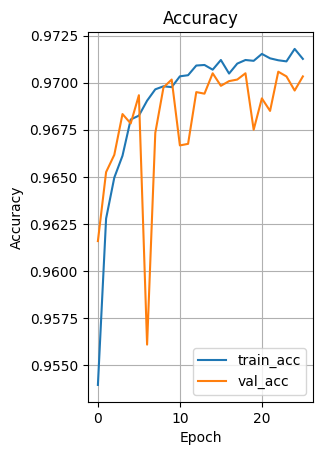

In [42]:

# Accuracy subplot
plt.subplot(1,2,1)
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='train_acc')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

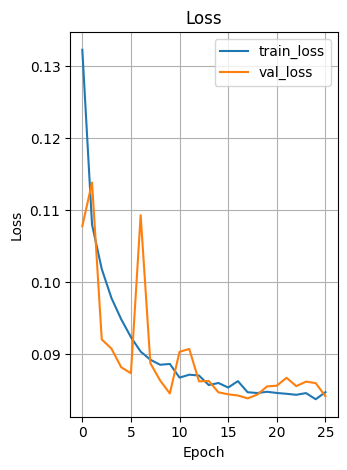

Saved training history plot to training_history.png


In [43]:
# Loss subplot
plt.subplot(1,2,2)
if 'loss' in history.history:
    plt.plot(history.history['loss'], label='train_loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(OUT_PLOT_HISTORY, dpi=200)
plt.show()
print(f"Saved training history plot to {OUT_PLOT_HISTORY}")

<function matplotlib.pyplot.colorbar(mappable: 'ScalarMappable | None' = None, cax: 'matplotlib.axes.Axes | None' = None, ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None, **kwargs) -> 'Colorbar'>

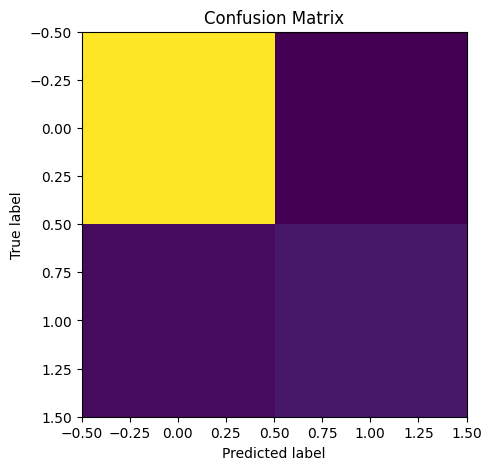

In [44]:
# 2) Confusion matrix heatmap
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar    


In [45]:
# Optionally, also print where outputs are saved.
print("All done — model and plots saved in current working directory.")

All done — model and plots saved in current working directory.
